In [5]:
%ls /main/external

 AversiveCoding.pdf*           models/
 bureaucratic/                 notes.md*
 data/                        'Overview - ADPV project.ods'*
 database/                     plots/
 derivation_CCA.pdf*           predictions_position_filtered.html*
 dimensionality-reduction/     presentation/
 ETL/                          questions.md*
 fuhrmann_data/                raw_data/
 fuhrmann.db*                  sagemath/
 fuhrmann.db.tmp/              spark-cluster/
 gallego_CCA_2020nature.pdf*   Surbhit/
 manuel_mittag.pdf*            tensorboard_runs/


In [1]:
import sys
sys.path.append(r'../')
import os
os.chdir('../')
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.decomposition import PCA
from functions import Database, preprocess_data, prep_data, BunDLeNet, train_model, plotting_neuronal_behavioural, plot_latent_timeseries, plot_phase_space, rotating_plot

%reload_ext autoreload
%autoreload 2

ModuleNotFoundError: No module named 'tensorflow'

## Load Data (excluding behavioural neurons)

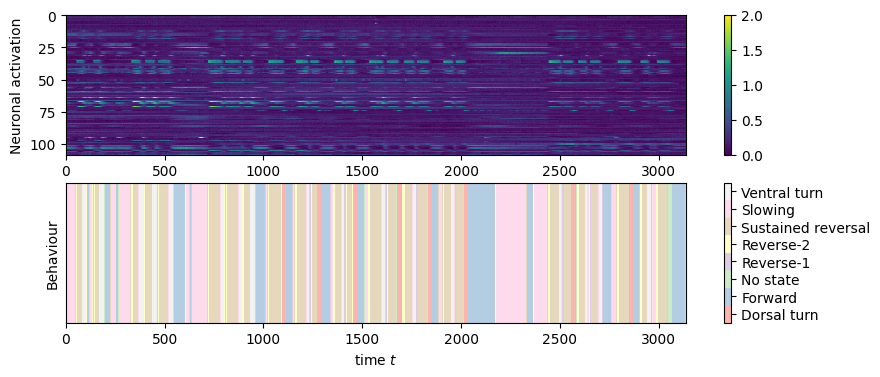

In [51]:
worm_num = 0
b_neurons = [
	'AVAR',
	'AVAL',
	'SMDVR',
	'SMDVL',
	'SMDDR',
	'SMDDL',
	'RIBR',
	'RIBL'
]
data = Database(data_set_no=worm_num)
# data.exclude_neurons(b_neurons)
X = data.neuron_traces.T
B = data.states
state_names = ['Dorsal turn', 'Forward', 'No state', 'Reverse-1', 'Reverse-2', 'Sustained reversal', 'Slowing', 'Ventral turn']
plotting_neuronal_behavioural(X, B, state_names=state_names)

## Preprocess data and embed with BunDLe-Net

In [52]:
### Preprocess and prepare data for BundLe Net
time, X = preprocess_data(X, data.fps)
X_, B_ = prep_data(X, B, win=15)

### Deploy BunDLe Net
model = BunDLeNet(latent_dim=3)
model.build(input_shape=X_.shape)
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001)

loss_array = train_model(
	X_,
	B_,
	model,
	optimizer,
	gamma=0.9, 
	n_epochs=2000,
	pca_init=False,
	best_of_5_init=False
)

Losses 0.006190 0.004152 0.010342: 100%|██████████| 2000/2000 [10:38<00:00,  3.13it/s]


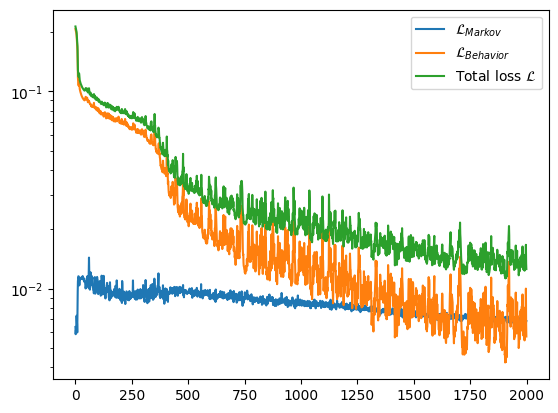

In [53]:
# Training losses vs epochs
plt.figure()
for i, label in  enumerate(["$\mathcal{L}_{{Markov}}$", "$\mathcal{L}_{{Behavior}}$","Total loss $\mathcal{L}$" ]):
	plt.semilogy(loss_array[:,i], label=label)
plt.legend()
plt.show()

## Projecting into latent space

In [54]:
Y0_ = model.tau(X_[:,0]).numpy() # X_[:, 0] extracts the first time step for each window. Y0_ is the latent representation of all the steps

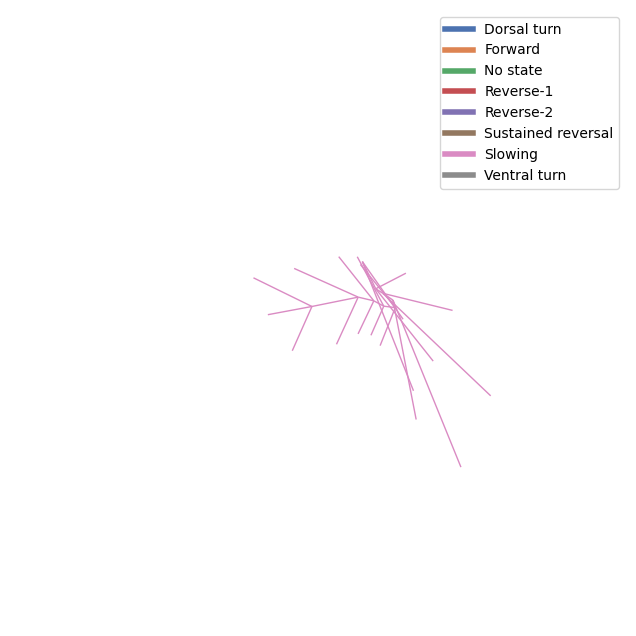

(<Figure size 800x800 with 1 Axes>, <Axes3D: >)

In [47]:
trial = model.tau(X_[:10,0]).numpy()

plot_phase_space(trial, B_[:10], state_names = state_names)

In [ ]:
print(X_[:,0].shape)

single_window = X_[0, 0]  # Shape: (15, 103)
single_window_flattened = single_window.flatten()  # Shape: (15*103 = 1545,)

# Ensure the tensor has the correct dtype (float32)
single_window_flattened = tf.convert_to_tensor(single_window_flattened, dtype=tf.float32)
dimension = X_[0, 0].shape[0] * X_[0, 0].shape[1]

# Pass through the model
single_window_transformed = model.tau(tf.reshape(single_window_flattened, (1, dimension)))  # Add batch dimension
print(single_window_transformed.numpy())  # Output the transformed latent representation




(3122, 15, 103)
[0.11086461 0.12164166 0.13223611 0.14253923 0.15244874 0.16187111
 0.17072354 0.17893547 0.18644975 0.19322334 0.19922758 0.20444811
 0.20888438 0.2125489  0.21546618]
[[ 0.40187052 -1.1147633   1.4284674 ]]


In [49]:
# Example sequence (time_series_length = 100, num_features = 103)
sequence = np.random.rand(100, 103)  # Shape: (100, 103)

sequence_, Bseq_ = prep_data(sequence, B[:sequence.shape[0]], win=15)
print(sequence_.shape)

(85, 2, 15, 103)


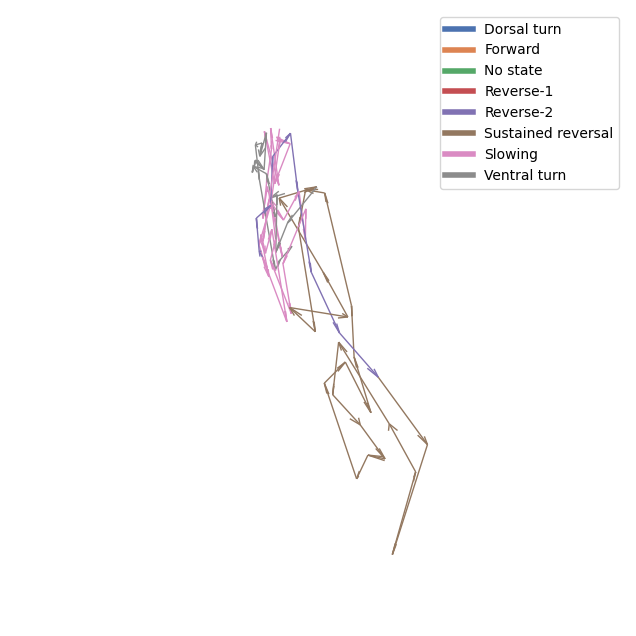

(<Figure size 800x800 with 1 Axes>, <Axes3D: >)

In [50]:
Y0_sequence_ = model.tau(sequence_[:,0]).numpy()
plot_phase_space(Y0_sequence_, Bseq_, state_names = state_names)

## Visualising embedding

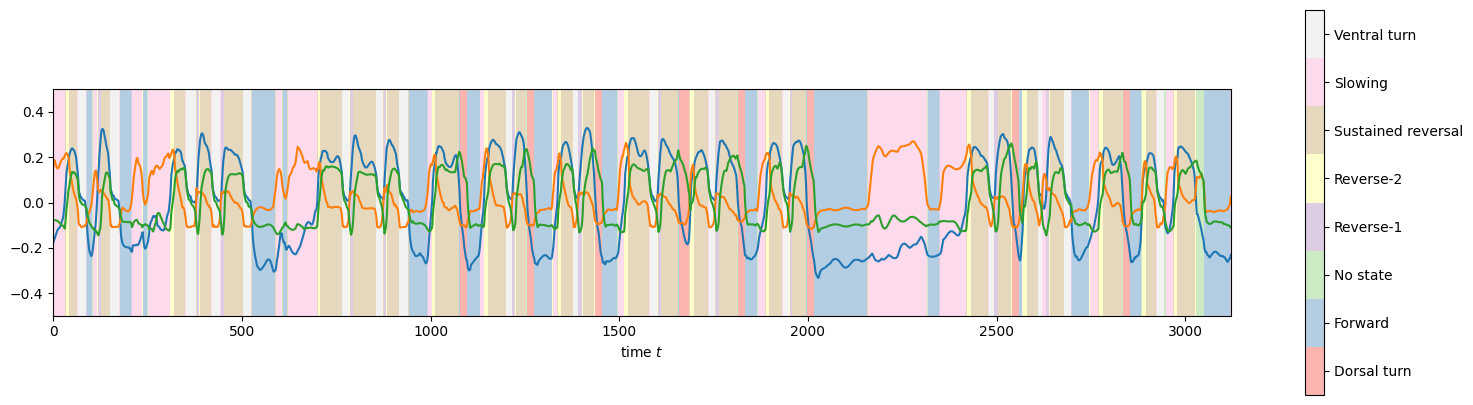

In [55]:
plot_latent_timeseries(Y0_, B_, state_names)

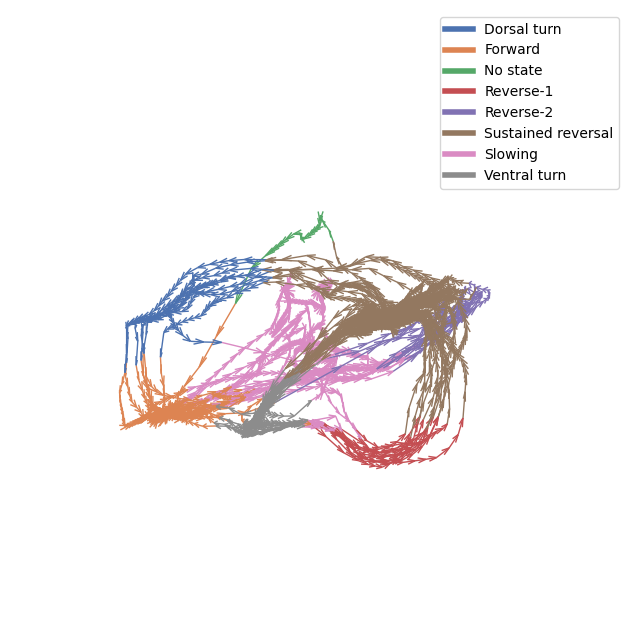

(<Figure size 800x800 with 1 Axes>, <Axes3D: >)

In [56]:
%matplotlib inline

plot_phase_space(Y0_, B_, state_names = state_names)

KeyboardInterrupt: 

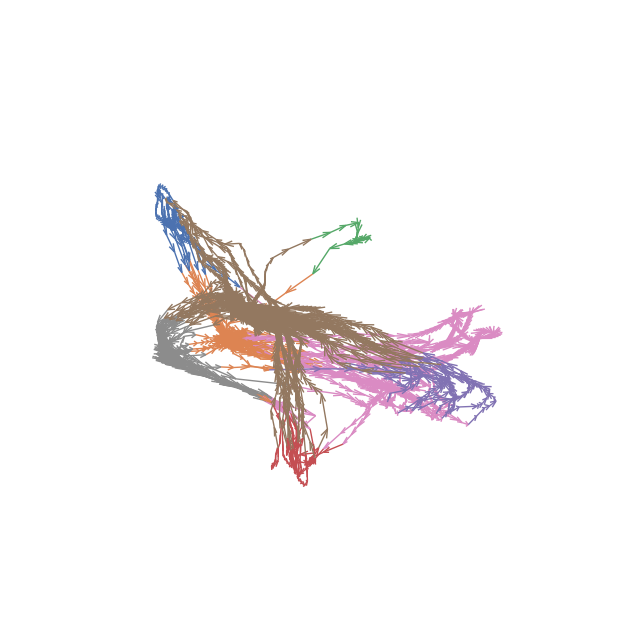

In [59]:
### Run to produce rotating 3-D plot
%matplotlib inline
algorithm = 'trial'

rotating_plot(Y0_, B_,filename='figures/rotation_'+ algorithm + '_worm_'+str(worm_num) +'.gif', state_names=state_names, legend=False)

### Performing PCA on the latent dimension (to check if there are redundant or correlated components)


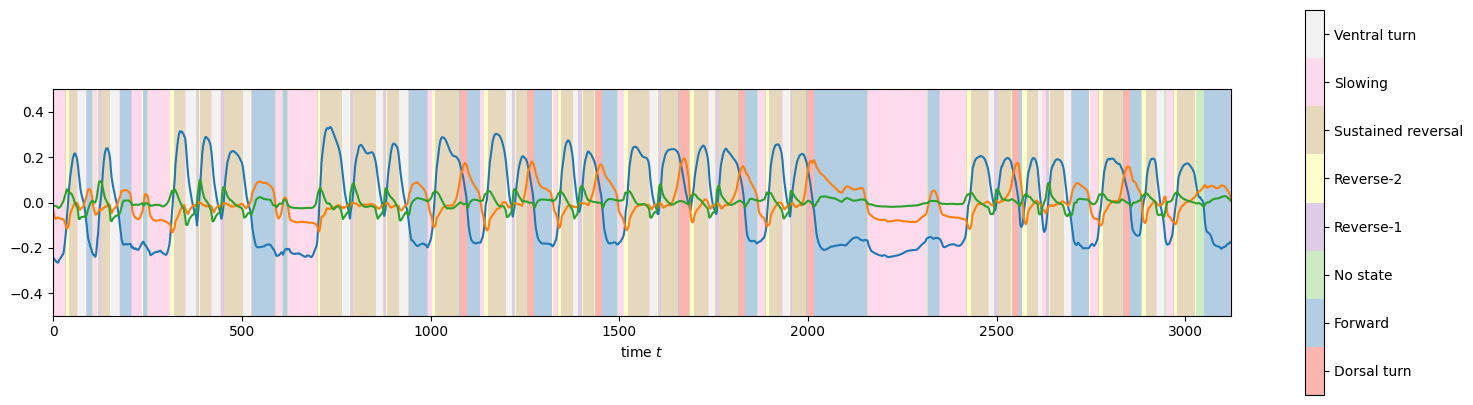

In [10]:
%matplotlib inline
pca = PCA()
Y_pca = pca.fit_transform(Y0_)
plot_latent_timeseries(Y_pca, B_, state_names)


### Recurrence plot analysis of BunDLeNet's embedding

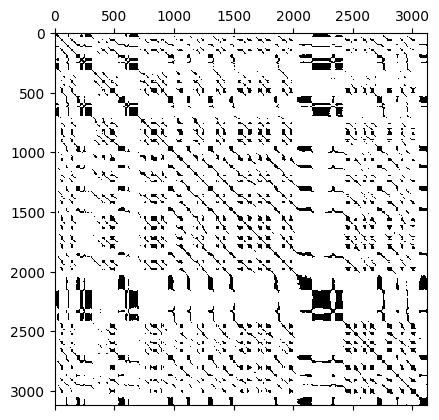

In [12]:
pd_Y = np.linalg.norm(Y0_[:, np.newaxis] - Y0_, axis=-1) < 0.8
plt.matshow(pd_Y, cmap='Greys')
plt.show()